For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude


## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback



print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [3]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [11]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.9344 - val_loss: 0.8354
Epoch 2/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9326 - val_loss: 0.8339
Epoch 3/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9308 - val_loss: 0.8324
Epoch 4/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9292 - val_loss: 0.8309
Epoch 5/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9275 - val_loss: 0.8295
Epoch 6/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9258 - val_loss: 0.8280
Epoch 7/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9242 - val_loss: 0.8266
Epoch 8/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9225 - val_loss: 0.8251
Epoch 9/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9209 - val_loss: 0.8237
Epoch 10/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.919

149/149 [==============================] - 0s 3ms/step - loss: 0.8176 - val_loss: 0.7315
Epoch 81/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8163 - val_loss: 0.7303
Epoch 82/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8149 - val_loss: 0.7290
Epoch 83/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8136 - val_loss: 0.7278
Epoch 84/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8122 - val_loss: 0.7266
Epoch 85/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8109 - val_loss: 0.7253
Epoch 86/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8095 - val_loss: 0.7241
Epoch 87/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8082 - val_loss: 0.7229
Epoch 88/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8068 - val_loss: 0.7217
Epoch 89/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8054 - v

149/149 [==============================] - 0s 2ms/step - loss: 0.7171 - val_loss: 0.6404
Epoch 160/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7159 - val_loss: 0.6392
Epoch 161/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7146 - val_loss: 0.6381
Epoch 162/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7133 - val_loss: 0.6369
Epoch 163/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7121 - val_loss: 0.6358
Epoch 164/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7108 - val_loss: 0.6347
Epoch 165/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7096 - val_loss: 0.6336
Epoch 166/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7084 - val_loss: 0.6324
Epoch 167/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7071 - val_loss: 0.6313
Epoch 168/1000
149/149 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6230 - val_loss: 0.5566
Epoch 239/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6218 - val_loss: 0.5556
Epoch 240/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6206 - val_loss: 0.5546
Epoch 241/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6195 - val_loss: 0.5535
Epoch 242/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6183 - val_loss: 0.5525
Epoch 243/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6171 - val_loss: 0.5514
Epoch 244/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6159 - val_loss: 0.5504
Epoch 245/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6147 - val_loss: 0.5493
Epoch 246/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6136 - val_loss: 0.5483
Epoch 247/1000
149/149 [==============================] - 0s 2ms

Epoch 317/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5346 - val_loss: 0.4791
Epoch 318/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5335 - val_loss: 0.4781
Epoch 319/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5324 - val_loss: 0.4772
Epoch 320/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5314 - val_loss: 0.4762
Epoch 321/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5303 - val_loss: 0.4753
Epoch 322/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5292 - val_loss: 0.4743
Epoch 323/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5281 - val_loss: 0.4734
Epoch 324/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5270 - val_loss: 0.4724
Epoch 325/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5260 - val_loss: 0.4715
Epoch 326/1000
149/149 [==============================] - 0s 2ms

Epoch 396/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4557 - val_loss: 0.4092
Epoch 397/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4548 - val_loss: 0.4084
Epoch 398/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4539 - val_loss: 0.4076
Epoch 399/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4529 - val_loss: 0.4067
Epoch 400/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4520 - val_loss: 0.4059
Epoch 401/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4511 - val_loss: 0.4051
Epoch 402/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4502 - val_loss: 0.4043
Epoch 403/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4493 - val_loss: 0.4035
Epoch 404/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4484 - val_loss: 0.4028
Epoch 405/1000
149/149 [==============================] - 0s 2ms

Epoch 475/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3913 - val_loss: 0.3535
Epoch 476/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3906 - val_loss: 0.3529
Epoch 477/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3899 - val_loss: 0.3523
Epoch 478/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3892 - val_loss: 0.3517
Epoch 479/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3885 - val_loss: 0.3511
Epoch 480/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3878 - val_loss: 0.3505
Epoch 481/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3871 - val_loss: 0.3498
Epoch 482/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3864 - val_loss: 0.3492
Epoch 483/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3857 - val_loss: 0.3486
Epoch 484/1000
149/149 [==============================] - 0s 2ms

Epoch 554/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3430 - val_loss: 0.3120
Epoch 555/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3425 - val_loss: 0.3116
Epoch 556/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3420 - val_loss: 0.3112
Epoch 557/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3415 - val_loss: 0.3107
Epoch 558/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3410 - val_loss: 0.3103
Epoch 559/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3405 - val_loss: 0.3099
Epoch 560/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3400 - val_loss: 0.3094
Epoch 561/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3395 - val_loss: 0.3090
Epoch 562/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3390 - val_loss: 0.3086
Epoch 563/1000
149/149 [==============================] - 0s 2ms

Epoch 633/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3086 - val_loss: 0.2827
Epoch 634/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3082 - val_loss: 0.2824
Epoch 635/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3079 - val_loss: 0.2821
Epoch 636/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3075 - val_loss: 0.2818
Epoch 637/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3072 - val_loss: 0.2815
Epoch 638/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3068 - val_loss: 0.2812
Epoch 639/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3065 - val_loss: 0.2809
Epoch 640/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3061 - val_loss: 0.2806
Epoch 641/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3058 - val_loss: 0.2803
Epoch 642/1000
149/149 [==============================] - 0s 2ms

Epoch 712/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2842 - val_loss: 0.2619
Epoch 713/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2839 - val_loss: 0.2617
Epoch 714/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2836 - val_loss: 0.2615
Epoch 715/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2834 - val_loss: 0.2613
Epoch 716/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2831 - val_loss: 0.2610
Epoch 717/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2829 - val_loss: 0.2608
Epoch 718/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2826 - val_loss: 0.2606
Epoch 719/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2823 - val_loss: 0.2604
Epoch 720/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2821 - val_loss: 0.2602
Epoch 721/1000
149/149 [==============================] - 0s 2ms

Epoch 791/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2658 - val_loss: 0.2469
Epoch 792/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2656 - val_loss: 0.2467
Epoch 793/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2653 - val_loss: 0.2465
Epoch 794/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2464
Epoch 795/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2649 - val_loss: 0.2462
Epoch 796/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2647 - val_loss: 0.2460
Epoch 797/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2645 - val_loss: 0.2459
Epoch 798/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2643 - val_loss: 0.2457
Epoch 799/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2641 - val_loss: 0.2455
Epoch 800/1000
149/149 [==============================] - 0s 2ms

Epoch 870/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2346
Epoch 871/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2504 - val_loss: 0.2345
Epoch 872/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2502 - val_loss: 0.2343
Epoch 873/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2500 - val_loss: 0.2342
Epoch 874/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2499 - val_loss: 0.2340
Epoch 875/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2497 - val_loss: 0.2339
Epoch 876/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2495 - val_loss: 0.2337
Epoch 877/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2493 - val_loss: 0.2336
Epoch 878/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2492 - val_loss: 0.2335
Epoch 879/1000
149/149 [==============================] - 0s 2ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

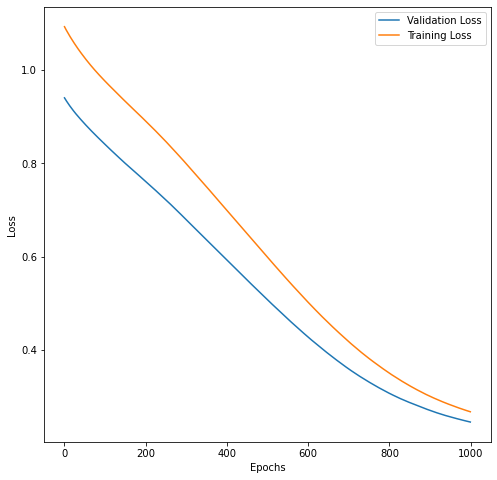

In [14]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

The `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

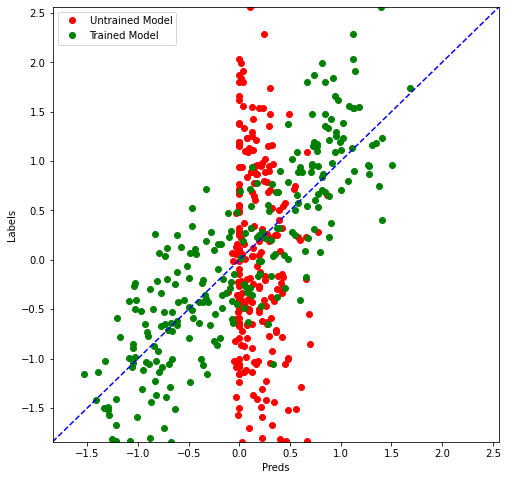

In [15]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

In [ ]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)